In [1]:
import numpy as np
import pandas as pd
import subprocess
import scipy.io
import os
import matplotlib.pyplot as plt
os.environ['LD_LIBRARY_PATH'] = '/global/home/groups/co_nuclear/gd_library/code/lib'
os.environ['LIBRARY_PATH'] = '/global/home/groups/co_nuclear/gd_library/code/lib'
os.environ['CPATH'] = '/global/home/groups/co_nuclear/gd_library/code/include'

In [2]:
def execute_bash_command(command):
    process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, shell=True)
    
    # Read the command output line by line and print it live
    while True:
        output = process.stdout.readline().decode('utf-8')
        if output == '' and process.poll() is not None:
            break
        if output:
            print(output.strip())
    
    # Wait for the command to finish and get the return code
    return_code = process.wait()
    
    return return_code

In [3]:
# Input
mat_name = 'fuel'
csv_file = '/global/scratch/users/yvesrobert/HxF/Cases/HTR-10_large_3/Data/core_750.csv'
binary_file = '/global/scratch/users/yvesrobert/HxF/Cases/HTR-10_large_3/wrk_Serpent/input.inp.wrk_750'
r_fuel = 0.025 
Ntrisos = 9000
vol_per_material = 4/3*np.pi*r_fuel**3*Ntrisos

# Nuclear data paths
acefile = "/global/home/groups/co_nuclear/serpent/xsdata/endfb7/sss_endfb7u.xsdata"
acefile_photons = "/global/home/groups/co_nuclear/serpent_photon_data/mcplib.xsdata"
decfile = "/global/home/groups/co_nuclear/serpent/xsdata/endfb7/sss_endfb7.dec"
pdatafile = "/global/home/groups/co_nuclear/serpent_photon_data/photon_data"

# Serpent executable
sss_exe = '/global/home/groups/co_nuclear/HxF_tools/serpent2.2.0_HxF_dev/sss2'
ncores = 20

In [230]:
# Read csv and find index of discharged pebbles
data = pd.read_csv(csv_file, index_col=0)
if 'fuel' in data.columns:
    data['isactive'] = data['fuel']
indices = data.loc[(data['recirculated'] & data['isactive'])].index.values + 1 

In [248]:
# Create materials file
with open('materials', 'w') as f:
    for i in indices[:4]:
        f.write(f'''mat {mat_name}z{i} -1 vol 1
92235.03c 1
cell c{i} 0 {mat_name}z{i}  -s1

''')

In [249]:
# Add to input file
with open('input', 'w') as f:
    f.write(f'''include materials

surf s1 sqc 0.0 0.0 0.0
cell cout 0 outside    s1

set acelib "{acefile}"% "{acefile_photons}"
set declib "{decfile}"
%set pdatadir "{pdatafile}"

set rfr continue "{binary_file}"

src 1 g sg -1 1
set pop 1000 1000 1000 %nps 1000''')


In [250]:
# Run serpent
command = f'{sss_exe} input -omp 20 -norun'
return_code = execute_bash_command(command)

print(f"Command finished with return code: {return_code}")


_                   .-=-.           .-=-.          .-==-.
{ }      __        .' O o '.       .' O o '.       /  -<' )--<
{ }    .' O'.     / o .-. O \     / o .-. O \     /  .---`
{ }   / .-. o\   /O  /   \  o\   /O  /   \  o\   /O /
\ `-` /   \ O`-'o  /     \  O`-'o  /     \  O`-`o /
`-.-`     '.____.'       `._____.'       `.____.'

Serpent 2.2

A Continuous-energy Monte Carlo Reactor Physics Burnup Calculation Code

- Version pre-2.2.1 (May 24, 2022) -- Contact: serpent@vtt.fi

- Reference: J. Leppanen, et al. "The Serpent Monte Carlo code: Status,
development and applications in 2013." Ann. Nucl. Energy,
82 (2015) 142-150.

- Compiled Jun 12 2023 15:38:01

- MPI Parallel calculation mode available

- OpenMP Parallel calculation mode available

- Geometry and mesh plotting available

- Default data path not set

- Full command used to run Serpent:

/global/home/groups/co_nuclear/HxF_tools/serpent2.2.0_HxF_dev/sss2
input -omp 20 -norun

Begin calculation on Fri Jun 23 17:44:42 2023 

In [5]:
gsrc_path = '/global/scratch/users/yvesrobert/HxF_dev/Tools/Makes_gammas/input_gsrc.m'
with open(gsrc_path, 'r') as file:
    lines = file.read().splitlines()
    
nlines = len(lines)
line_idx = 0
materials = {}
while line_idx < nlines:
    while mat_name not in lines[line_idx]:
        line_idx +=1
        if line_idx >= nlines:
            break
    if line_idx >= nlines:
        break
    zone = int(lines[line_idx].split(f'{mat_name}z')[1].split(' =')[0].split('_')[0])
    if f'{mat_name}z{zone}' not in materials:
        line_idx +=1
        table = []
        while '];' not in lines[line_idx]:
            if lines[line_idx] and lines[line_idx][0] != '%':
                table.append([int(lines[line_idx].split()[0])] + [float(i) for i in lines[line_idx].split()[1:]])
            line_idx +=1
        materials[f'{mat_name}z{zone}'] = pd.DataFrame(table, columns = ['ZAI', 'Specific intensity', 'Total emission rate', 'Cumulative material fraction', 'Energy', 'Relative intensity', 'Cumulative nuclide total'])
        materials[f'{mat_name}z{zone}']['Energy emission rate'] = materials[f'{mat_name}z{zone}']['Relative intensity']/materials[f'{mat_name}z{zone}']['Specific intensity']*materials[f'{mat_name}z{zone}']['Total emission rate']
    line_idx +=1
    
print(f'Found {len(materials)} materials')

Found 4 materials


In [7]:
materials['fuelz38']

,ZAI,Specific intensity,Total emission rate,Cumulative material fraction,Energy,Relative intensity,Cumulative nuclide total,Energy emission rate
0,932390,1.614240,9.401030e+12,0.048756,0.014300,4.951350e-01,0.306729,2.883573e+12
1,932390,1.614240,9.401030e+12,0.048756,0.106123,2.773180e-01,0.478523,1.615048e+12
2,932390,1.614240,9.401030e+12,0.048756,0.103374,2.203060e-01,0.614999,1.283021e+12
3,932390,1.614240,9.401030e+12,0.048756,0.277599,1.519780e-01,0.709147,8.850913e+11
4,932390,1.614240,9.401030e+12,0.048756,0.099525,1.387290e-01,0.795088,8.079316e+11
...,...,...,...,...,...,...,...,...
20949,501130,0.801597,2.229250e-04,1.000000,0.255134,2.110000e-02,0.977673,5.867933e-06
20950,501130,0.801597,2.229250e-04,1.000000,0.027863,1.788690e-02,0.999987,4.974366e-06
20951,501130,0.801597,2.229250e-04,1.000000,0.638030,9.700000e-06,0.999999,2.697581e-09
20952,501130,0.801597,2.229250e-04,1.000000,0.382900,6.000000e-07,1.000000,1.668607e-10


In [8]:
materials['fuelz38'][materials['fuelz38'].ZAI==551370]

,ZAI,Specific intensity,Total emission rate,Cumulative material fraction,Energy,Relative intensity,Cumulative nuclide total,Energy emission rate
15152,551370,0.000006,252958.0,1.0,0.2835,0.000006,1.0,252958.0


In [ ]:
materials['fuelz38'].groupby('ZAI').mean()

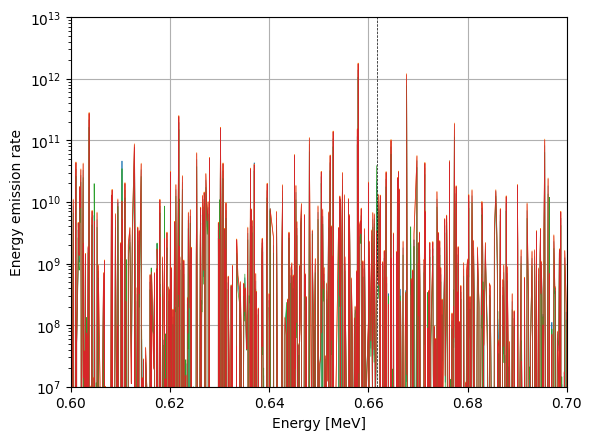

In [119]:
def cumulate_gamma(material_df, vol_per_material=1, resolution=None):
    if not resolution:
        new_table = material_df.groupby('Energy').agg({"ZAI": list, "Energy emission rate": "sum"})
    else:
        bins = np.arange(material_df['Energy'].min(), material_df['Energy'].max()+resolution/2, resolution)
        cut_data = pd.cut(material_df['Energy'], bins=bins).apply(lambda x: x.mid)
        new_table = material_df.groupby(cut_data).agg({"ZAI": list, "Energy emission rate": "sum"})
    new_table["Energy emission rate"] *= vol_per_material
    return new_table.sort_index()


def plot_gamma(material_df, y='Energy emission rate', vol_per_material=1, resolution=None, logx=True, logy=True, linewidth=0.5):
    table = cumulate_gamma(material_df, vol_per_material=vol_per_material, resolution=resolution)
    plt.plot(table.index, table[y], linewidth=linewidth)
    plt.xlabel('Energy [MeV]')
    plt.ylabel(y)
    plt.grid(visible=True)
    if logx:
        plt.xscale('log')
    if logy:
        plt.yscale('log')    
    plt.gca().autoscale_view()

res = None
for mat_name in materials:
    plot_gamma(materials[mat_name], logx=False, resolution=res, vol_per_material=vol_per_material)
    # plt.ylim(bottom=1e7)
#     cumulate_gamma(mat, vol_per_material, resolution=res)
    plt.xlim([0.6,0.7])
    plt.ylim([1e7, 1e13])
plt.axvline(661.7e-3, linestyle='--', color='k', linewidth=0.5)

In [114]:
cs137 = pd.DataFrame(index=materials.keys(), columns=materials[list(materials)[0]].columns)
for mat_name in materials:
    cs137.loc[mat_name] = materials[mat_name][(materials[mat_name]['ZAI']==561371) & ((materials[mat_name]['Energy']-661.7e-3).abs()<1e-3)].values
    
cs137

,ZAI,Specific intensity,Total emission rate,Cumulative material fraction,Energy,Relative intensity,Cumulative nuclide total,Energy emission rate
fuelz38,561371.0,0.983433,40644300000.0,0.99575,0.661657,0.9011,0.91628,37241559648.700012
fuelz95,561371.0,0.983433,2419480000.0,0.999815,0.661657,0.9011,0.91628,2216921160.872169
fuelz97,561371.0,0.983433,71989900000.0,0.989868,0.661657,0.9011,0.91628,65962906359.660492
fuelz123,561371.0,0.983433,2336930000.0,0.99981,0.661657,0.9011,0.91628,2141282245.968968


In [101]:
materials[mat_name][materials[mat_name]['ZAI']==551370]

,ZAI,Specific intensity,Total emission rate,Cumulative material fraction,Energy,Relative intensity,Cumulative nuclide total,Energy emission rate
15152,551370,0.000006,252958.0,1.0,0.2835,0.000006,1.0,252958.0


In [91]:
materials[mat_name][materials[mat_name]['ZAI']==551370]

,ZAI,Specific intensity,Total emission rate,Cumulative material fraction,Energy,Relative intensity,Cumulative nuclide total,Energy emission rate
15152,551370,0.000006,252958.0,1.0,0.2835,0.000006,1.0,252958.0


In [64]:
pd.cut(mat['Energy'], bins=1000)

/global/scratch/users/yvesrobert/conda/kraken/lib/python3.8/site-packages/IPython/lib/pretty.py:778: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  output = repr(obj)


0        0.011325
1        0.109500
2        0.102400
3        0.277500
4        0.102400
           ...   
20949    0.256500
20950    0.025300
20951    0.641500
20952    0.382500
20953    0.648500
Name: Energy, Length: 20954, dtype: category
Categories (1000, float64): [0.000850 < 0.011325 < 0.018300 < 0.025300 ... 6.9755 < 6.9825 < 6.9895 < 6.9965]

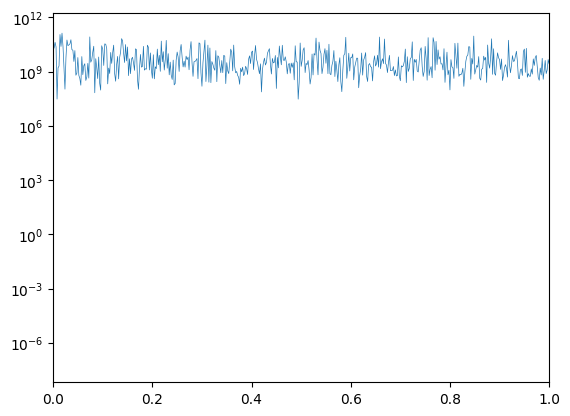

In [54]:
table = cumulate_gamma(mat, vol_per_material)
dE = 2e-3
table_avg = table.groupby(pd.cut(table.index, bins=np.arange(table.index.min(), table.index.max()+dE/2, dE)))['Energy emission rate'].mean()
plt.plot([i.mid for i in table_avg.index], table_avg, linewidth=0.5)
plt.xlim([0,1])
plt.yscale('log')

In [43]:
np.arange(table['Energy emission rate'].min(), table['Energy emission rate'].max()+dE/2, dE)

MemoryError: Unable to allocate 12.6 PiB for an array with shape (1768452564058425,) and data type float64

<Axes: xlabel='ZAI'>

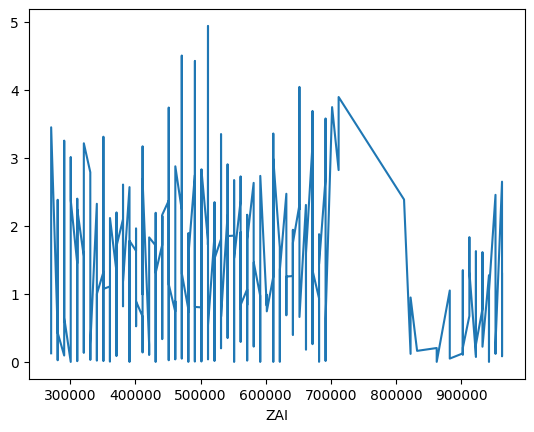

In [23]:
mat.groupby('ZAI').mean()['Specific intensity'].plot()

In [ ]:
table = cumulate_gamma(mat, vol_per_material)
table.sum()['Energy emission rate']/1e14

In [ ]:
plt.bar(E_grid, rates, width=np.diff(E_grid)[0])
plt.yscale('log')

In [ ]:
table.index

In [ ]:
table = cumulate_gamma(mat)
table.loc[((table.index>6.615e-1) & (table.index<6.63e-1))].sort_values('Energy emission rate')